In [1]:
import os
import pandas as pd
import numpy as np
import rasterio
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def load_data(paths):
    # Get a list of all files in the directory (X_train, y_train, X_test)
    file_list = [[file for file in os.listdir(paths) if file.endswith('.tif')] for paths in directory_paths]

    # Sort the file list to ensure consistent order
    file_list = [sorted(files) for files in file_list]

    # Initialize an empty array to store the image data
    X_train, y_train, X_test = [], [], []

    # Iterate through the selected files
    for X_train_name, y_train_name in tqdm(zip(file_list[0], file_list[1])):
        # Construct the full path to the file
        X_train_path = os.path.join(paths[0], X_train_name)
        y_train_path = os.path.join(paths[1], y_train_name)

        # Open the raster file using rasterio
        with rasterio.open(X_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            X_train.append(image_data)

        # Open the raster file using rasterio
        with rasterio.open(y_train_path) as src:
            # Read the entire image data as a NumPy array
            image_data = src.read()

            # Append the image data to the array
            y_train.append(image_data)

    # Convert the list of arrays to a single NumPy array
    X_train = np.array(X_train)
    y_train = np.array(y_train)

    return X_train, y_train

In [3]:
directory_paths = ['../data/raw/train_satellite', '../data/raw/train_kelp']
os.path.abspath(directory_paths[0])
X_train, y_train = load_data(directory_paths)

print("Shape of the X_train array:", X_train.shape)
print("Shape of the y_train array:", y_train.shape)

0it [00:00, ?it/s]

C:\Users\EmielW\Epoch\Competitions\q2-detect-kelp\venv\Lib\site-packages\rasterio\__init__.py:317: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


Shape of the X_train array: (5634, 7, 350, 350)
Shape of the y_train array: (5634, 1, 350, 350)


In [4]:
import scipy


def reshape(img: np.ndarray):
    img = img.transpose(1,2,0)
    img = img.reshape(-1,img.shape[2])
    return img

def to_df(img: np.ndarray, label: np.ndarray):
    
    # Create a dataframe with the base features
    df = pd.DataFrame(reshape(img), columns=['SWIR','NIR', 'R', 'G', 'B','Cloud','Elevation'])
    df['Water'] = df['Elevation'] < 1
    
    df['NDWI'] = (df['G'] - df['NIR']) / (df['G'] + df['NIR'])
    df['MNDWI'] = (df['G'] - df['SWIR']) / (df['G'] + df['SWIR'])
    df['NDVI'] = (df['NIR'] - df['R']) / (df['NIR'] + df['R'])
    
    # Land closeness, roughly inverse distance to land
    land_dist = scipy.ndimage.distance_transform_edt(img[6, :, :] <= 0)
    land_closeness = 1 / (1 + land_dist * 0.1)
    df['LandCloseness'] = land_closeness.flatten()
    
    # Offset features, using difference with median of all water pixels
    if df['Water'].sum() > 0:
        df['ONIR'] = df['NIR'] - df[df['Water']]['NIR'].median() 
        
        ROffset = df['R'] - df[df['Water']]['R'].median()
        GOffset = df['G'] - df[df['Water']]['G'].median()
        df['ODWI'] = (GOffset - df['ONIR'])
        df['ODVI'] = (df['ONIR'] - ROffset)
    else:
        df['ONIR'] = 0
        df['ODWI'] = 0
        df['ODVI'] = 0
        
    
    # Add the label to the dataframe
    df['Label'] = label.flatten()
    return df

In [5]:
# Get the last N images for testing (trained on the first 3000)
N = 1000
X_test = pd.concat([to_df(X_train[-i], y_train[-i]) for i in tqdm(range(1, N+1))])

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
# load the catboost_model.cbm
from catboost import CatBoostClassifier
model = CatBoostClassifier()
model.load_model('./catboost_model.cbm')

# load the catboost_features.txt
with open('./catboost_features.txt') as f:
    features = f.read().splitlines()

In [9]:
# Make predictions on the test data
y_pred = model.predict_proba(X_test[features])[:, 1]

In [12]:
def blur_preds(pred: np.ndarray, sigma: float = 3):
    """Given the flat predictions one or more images, blur the predictions in 2D and flatten again"""
    img = pred.reshape(-1, 350, 350)
    img = scipy.ndimage.gaussian_filter(img, sigma=sigma)
    return img.flatten()

def get_dice(pred: np.ndarray, label: np.ndarray, thresh: float = 0.5):
    """Given the flat predictions of single image, calculate the dice score"""
    pred = pred > thresh
    return 2 * np.sum(pred * label) / (np.sum(pred) + np.sum(label))

In [34]:
# Perform a grid search over blur sigma and threshold
results = []
sigmas = np.arange(0, 3, 0.2)
threshs = np.arange(0, 0.8, 0.025)
pbar = tqdm(total=len(sigmas) * len(threshs))
for sigma in sigmas:
    y_pred_blur = blur_preds(y_pred, sigma=sigma)
    for thresh in threshs:
        dice = get_dice(y_pred_blur, X_test['Label'], thresh=thresh)
        results.append([sigma, thresh, dice])
        pbar.update(1)

  0%|          | 0/480 [00:00<?, ?it/s]

In [35]:
# record the results in a dataframe
df = pd.DataFrame(results, columns=['sigma', 'thresh', 'dice'])

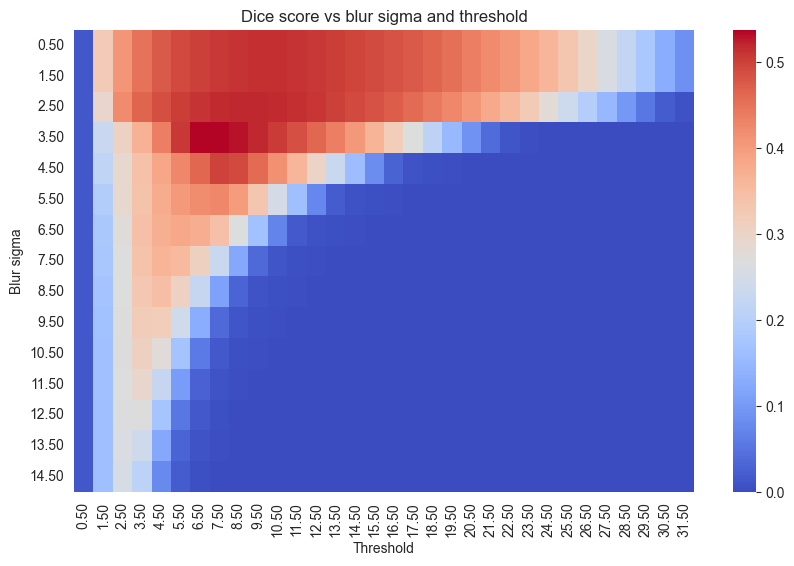

In [36]:
# Plot the results in a heatmap
plt.figure(figsize=(10, 6))
arr = df.pivot(index='sigma', columns='thresh', values='dice')
sns.heatmap(arr, cmap='coolwarm')
plt.title('Dice score vs blur sigma and threshold')
plt.xlabel('Threshold')
plt.ylabel('Blur sigma')
plt.gca().xaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter('{:.2f}'.format))
plt.show()

In [52]:
# print the default score from the dataframe (no blur)
print("Default score:")
default = df[(df['sigma'] == 0) & (df['thresh'] == 0.5)]
print(f'No blur, thresh 0.50: {default["dice"].values[0]:.4f}')

print("\nOptimising thresh:")
no_blur = df[df['sigma'] == 0]
best_thresh_no_blur = no_blur.sort_values('dice', ascending=False).iloc[0, 1]
print(f'No blur, thresh {best_thresh_no_blur}: {no_blur["dice"].max():.4f}')


# Get the best sigma and threshold
best_sigma, best_thresh = df.sort_values('dice', ascending=False).iloc[0, :2]
print("\nOptimising both:")
print(f'Best sigma: {best_sigma:.2f}')
print(f'Best threshold: {best_thresh:.2f}')
print(f'Best dice score: {df["dice"].max():.4f}')

Default score:
No blur, thresh 0.50: 0.4367

Optimising thresh:
No blur, thresh 0.25: 0.5137

Optimising both:
Best sigma: 0.60
Best threshold: 0.15
Best dice score: 0.5376
